## <span style="color:green">**Version en cours**</span>

# Segmentez des clients d'un site e-commerce
## Notebook 2 : Feature ingineering
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Présentation du projet

**Contexte**  


* Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.  
* Dans un premier temps il est demandé de réaliser quelques requêtes pour le dashboard à partir de la base de données SQLite d'Olist.  
* La mission principale est de fournir aux équipes d'e-commerce d'Olist une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

**Démarche globale**  
* Requêtes SQL pour le dashboard (cf Notebook 1)  
* **Feature ingineering** : c'est l'objet de ce notebook
* Tests de modèles de clustering (Notebook 3)  
* Simulation d'un contrat de maintenace (Notebbok 4)  

**Feature ingineering**  
* Objectif :
   * Préparer un dataset qui servira de base aux algorithmes de clustering testés à l'étape suivante  
   * Chaque ligne représentera un client, chaque colonne une feature caractérisant les clients
* Préparation des données pour les algorithmes envisagés (KMeans, DBSCAN, Agglomerative Hierarchical Clustering) :
   * Traitement des valeurs manquantes
   * Traitement des valeurs aberrantes
   * Normalisation / standardisation
   * Encodage des variables catégorielles
* Sélection des features pour réaliser une segmentation des clients de type **RFM** :
   * **R**écence : Nombre de jours écoulés depuis le dernier achat  
   * **F**réquence : Nombre total d'achats effectués par un client  
   * **M**ontant : Montant total dépensé par un client  

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions

**Chargement des données**
* Schéma relationnel   
* Création des dataframes des tables

**Création des features**  
* Feature `Récence`
* Feature `Fréquence`
* Feature `Montant`
* Création du dataframe `df_features`
* Normalisation

**Préparation du dataset**  
* Aperçu
* Mise en forme
* Enregistrement

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('pandas')
install_package('numpy')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')

pandas est déjà installé.
numpy est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
scikit-learn est déjà installé.


* Import des modules

In [4]:
# Import des modules
import os
import pandas as pd
import numpy as np
#import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer

## 1.3 Fonctions

In [5]:
# Renvoit le résultat d'une requête SQL
def query_result(query: str, all_rows: bool=True):
    with sqlite3.connect('olist.db') as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        if all_rows:
            result = cursor.fetchall()
        else:
            result = cursor.fetchone()
            if len(result) == 1:
                result = result[0]
    return result

In [6]:
# Renvoit le résultat d'une requête SQL sous forme de dataframe
def f_query_result(query: str):
    """Renvoit un dataframe contenant le résultat de la requête SQL passée en paramètre sous forme d'un string
    Le fichier de la BDD SQLite 'olist.db' doit être présent dans le répertoire courant.
    """
    with sqlite3.connect('olist.db') as conn:
        df = pd.read_sql_query(query, conn)
    return df

In [7]:
def create_dataframe_and_csv_if_not_exist_from_table(tablename: str):
    """Renvoit un dataframe contenant le contenu de la table passée en paramètre sous forme d'un string
    - Si le fichier csv de la table df_{tablename}.csv n'existe pas :
        * Utilisation de la fonction 'f_query_result' pour récupérer le contenu de la table dans un dataframe
        * Enregistrement du fichier csv
    - Si le fichier csv existe, lecture de son contenu dans un dataframe
    """
    filename = f"df_{tablename}.csv"
    if not os.path.exists(filename):
        query = f'SELECT * FROM {tablename};'
        df = f_query_result(query)
        df.drop(columns='index', inplace=True)
        df.to_csv(filename, index=False)
    else:
        df = pd.read_csv(filename)
    return df

In [8]:
# Description des variables d'un dataframe
def get_dataframe_infos(df):
    """Examine le dataframe (ou la series) 'df' fourni en paramètre et renvoit un dataframe 'df_infos' composé des variables :
       - 'Colonne' : nom des variables de df
       - 'Type' : type de la colonne
       - 'Valeurs uniques' : nombre de valeurs unique de la colonne
       - 'Valeurs manquantes' : nombre de valeurs manquantes de la colonne
       - '% valeurs manquantes' : pourcentage de valeurs manquantes de la colonne
       - 'Doublons' : nombre de valeurs non uniques (doublons) de la colonne
    """
    if isinstance(df, pd.Series):
        df = df.to_frame()
    number_of_rows = df.shape[0]
    col_names = df.columns
    col_types = df.dtypes
    unique_values = df.nunique()
    missing_values = df.isnull().sum()
    non_missing_values = number_of_rows - missing_values
    duplicate_values = non_missing_values - unique_values

    df_infos = pd.DataFrame({
        'Colonne': col_names,
        'Type': col_types,
        'Valeurs uniques': unique_values,
        'Doublons': duplicate_values,
        'Valeurs manquantes': missing_values,
        '% valeurs manquantes': round((missing_values / number_of_rows) * 100, 2).astype(str) + " %"
    }).reset_index(drop=True)

    return df_infos

In [9]:
# Affiche l'histogramme et le boxplot d'une feature
def plot_distribution(dataframe, feature, x_label, y_label, x_tick_angle=None):
    fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    plt.subplots_adjust(hspace=0.05)  # Ajuste l'espace entre les graphiques
    
    # Histogramme
    sns.histplot(dataframe[feature], bins=50, kde=True, ax=axs[0])
    axs[0].set_title(f'Distribution {feature}', pad=10)
    axs[0].set_xlabel('')  # Supprime le label de l'axe x pour l'histogramme
    axs[0].set_ylabel(y_label)
    axs[0].grid(linewidth=0.25)
    
    # Boxplot
    sns.boxplot(x=dataframe[feature], ax=axs[1])
    axs[1].set_xlabel(x_label)
    axs[1].set_yticks([])  # Supprime les ticks de l'axe y pour le boxplot

    if x_tick_angle is not None:
        for axis in axs:
            for label in axis.get_xticklabels():
                label.set_rotation(x_tick_angle)

    plt.show()

# 2 Chargement des données

## 2.1 Schéma relationnel

La réalisation des quelques requêtes pour le dashboard (Notebook 1) a été l'occasion d'étudier les relations entre les tables de la BDD Olist et d'établir le schema relationnel :

![shema relationnel](schema_relationnel_olist.png "Shéma relationnel BDD olist")

## 2.2 Création des dataframes des tables

* Chargement des fichiers csv dans le dataframe correspondant  
* Si le fichier csv n'existe pas, il est créé après avoir lu le contenu de la table dans la BDD

In [10]:
df_customers = create_dataframe_and_csv_if_not_exist_from_table('customers')
df_orders = create_dataframe_and_csv_if_not_exist_from_table('orders')
df_order_items = create_dataframe_and_csv_if_not_exist_from_table('order_items')
df_order_reviews = create_dataframe_and_csv_if_not_exist_from_table('order_reviews')
# df_order_pymts = create_dataframe_and_csv_if_not_exist_from_table('order_pymts')
# df_geoloc = create_dataframe_and_csv_if_not_exist_from_table('geoloc')
# df_products = create_dataframe_and_csv_if_not_exist_from_table('products')
# df_sellers = create_dataframe_and_csv_if_not_exist_from_table('sellers')
# df_translation = create_dataframe_and_csv_if_not_exist_from_table('translation')

## 2.3 Création d'un dataset complet

* L'obectif est de rassembler au sein d'un unique dataframe l'ensemble des données permettant de calculer les features RFM et le score de satisfaction

### 2.3.1 Calcul du montant de chaque commande

* La table `order_items` contient une ligne par unité de produit acheté
* En regroupant par `order_id` on peut calculer le montant dépensé d'une commande, sachant que ce montant se décompose en prix du produit (`price`) + frais de livraison (`freight_value`)

In [11]:
# Prix total et frais de livraison par commande
df_amount_by_order_id = df_order_items.groupby('order_id').agg(
    price_amount = ('price', 'sum'),
    freight_amount = ('freight_value', 'sum')
).reset_index()

# Calcul du montant total (total_price + total_freight) par commande
df_amount_by_order_id['total_price'] = df_amount_by_order_id['price_amount'] + df_amount_by_order_id['freight_amount']

### 2.3.2 Calcul de la note de satisfaction moyenne

* Les notes de satisfaction ne seront pas utilisées pour la segmentation des clients car elles n'entrent pas dans le cadre d'une analyse RFM
* Elles pourront cependant apporter une caractéristique supplémentaire aux profils des clients
* Un client peut avoir évalué plusieurs fois une même commande
* En regroupant par `order_id` on peut calculer le score de satisfaction moyen pour chaque commande

In [12]:
# Score de statisfaction moyen par commande
df_review_score_by_order_id = df_order_reviews.groupby('order_id').agg(satisfaction = ('review_score', 'mean')).reset_index()

### 2.3.3 Fusion des dataframes

* Récupération des id de clients uniques, ayant passé au moins une commande, avec les numéros et dates de commandes
* Certaines commandes ont été annulées (`order_status=='canceled'`), il faut les exclure

In [13]:
# Filtre pour exclure les commandes annulées
df_valid_orders = df_orders[df_orders['order_status'] != 'canceled']

# Fusion des dataframes 'df_customers' et 'df_orders'
df_data = pd.merge(
    df_customers[['customer_unique_id', 'customer_id']],
    df_valid_orders[['customer_id', 'order_id', 'order_purchase_timestamp']],
    on='customer_id',
    how='inner'
)

* Ajout du montant dépensé pour chaque commande

In [14]:
# Ajout du montant dépensé par fusion avec le dataframe 'df_amount_by_order_id'
df_data = pd.merge(
    df_data,
    df_amount_by_order_id[['order_id', 'total_price']],
    on='order_id',
    how='inner'
)

* Ajout des scores de satisfaction pour toutes les commandes : les commandes n'ayant pas fait l'objet d'une évaluation sont conservées avec la feature `satisfaction` à NaN

In [15]:
# Ajout des scores de satisfaction
df_data = pd.merge(
    df_data,
    df_review_score_by_order_id,
    on='order_id',
    how='left'
)

### 2.3.3 Analyse du dataset

* Affichage des permières et dernières lignes du dataframe constitué

In [16]:
# Affichage des première et dernières lignes
display(df_data)

,customer_unique_id,customer_id,order_id,order_purchase_timestamp,total_price,satisfaction
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,146.87,4.0
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,335.48,5.0
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,157.73,5.0
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,173.30,5.0
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,252.25,5.0
...,...,...,...,...,...,...
98200,1a29b476fee25c95fbafc67c5ac95cf8,17ddf5dd5d51696bb3d7c6291687be6f,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 15:48:17,88.78,4.0
98201,d52a67c98be1cf6a5c84435bd38d095d,e7b71a9017aa05c9a7fd292d714858e8,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:20:22,129.06,5.0
98202,e9f50caf99f032f0bf3c55141f019d99,5e28dfe12db7fb50a4b2f691faecea5e,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:11:50,56.04,1.0
98203,73c2643a0a458b49f58cea58833b192e,56b18e2166679b8a959d72dd06da27f9,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,711.07,5.0


* Ce dataframe contient une ligne par commande, avec :  
   * L'id de client qui l'dentifie de manière unique : `customer_unique_id`  
   * Le numéro de commande correspondant : `customer_id` (relie la commande au client), ou `order_id` (relie la commande au(x) unité(s) de produits et au `review_score`)
   * La date de la commande : `order_purchase_timestamp`
   * Le montant dépensé par le client pour cette unité de produit dans cette commande : `total_price`
   * Le score de satisfaction moyen de la commande, si elle a été évaluée : `satisfaction`

* Description des variables

In [17]:
# Affichage des informations générales
display(get_dataframe_infos(df_data))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,customer_unique_id,object,94989,3216,0,0.0 %
1,customer_id,object,98205,0,0,0.0 %
2,order_id,object,98205,0,0,0.0 %
3,order_purchase_timestamp,object,97653,552,0,0.0 %
4,total_price,float64,30922,67283,0,0.0 %
5,satisfaction,float64,11,97462,732,0.75 %


#### 2.3.3.1 Variable `order_purchase_timestamp`

In [18]:
# Conversion de la date d'achat au format datetime "YYYY-MM-DD 00:00:00"
df_data['order_purchase_timestamp'] = pd.to_datetime(df_data['order_purchase_timestamp']).dt.normalize()

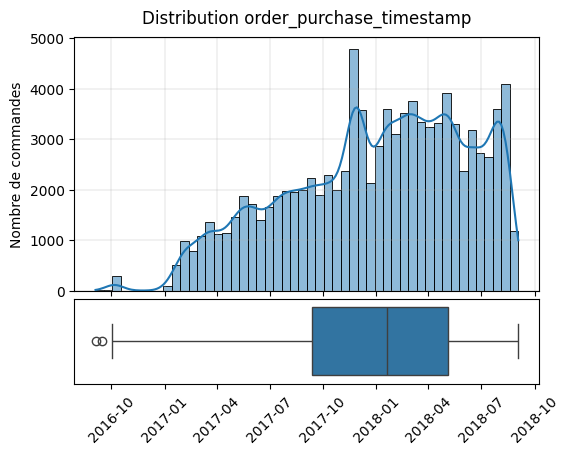

In [19]:
plot_distribution(df_data, 'order_purchase_timestamp', '', 'Nombre de commandes', x_tick_angle=45)

* Valeurs aberrantes
   * Certaines commandes ont été passées **avant janvier 2017**, or il est précisé :
      > *"Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients **depuis janvier 2017**."*  
   * Il n'y a pas de valeurs aberrantes en fin de période, dans le sens ou il n'y a pas de dates d'achat après le 3ème quartile + 1.5 x l'IQR, mais on constate **une chute du nombre de commandes**.  

* Les commandes passées avant le 1er janvier 2017 devront être exclues
* Quelle que soit la raison de la chute du nombre de commandes en fin de période, il sera préférable d'exclure les données de cette période

* Répartition mensuelles des commandes 

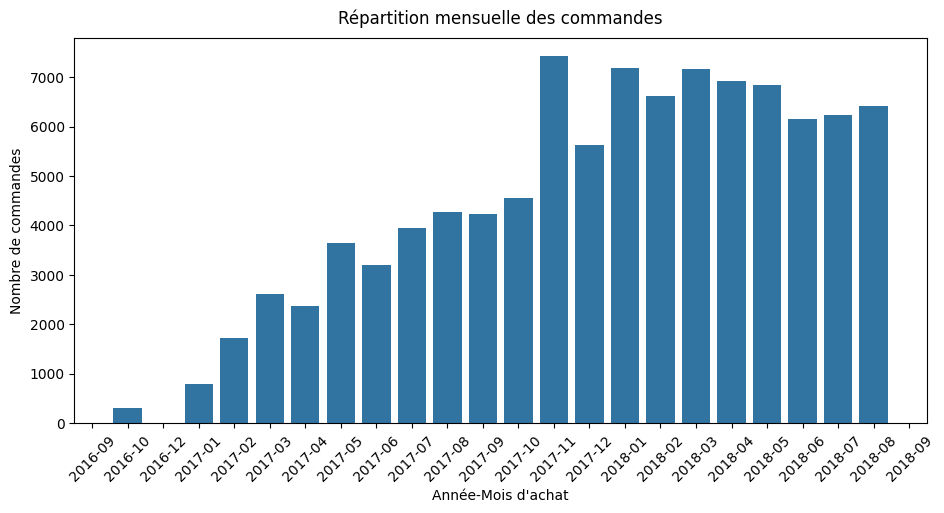

In [20]:
# Ajout de la colonne 'year_month'
df_data['year_month'] = df_data['order_purchase_timestamp'].dt.to_period('M')

# Nombre de commandes passées pour chaque valeur de 'year_month'
df_orders_by_year_month = df_data.groupby('year_month')['order_id'].count().reset_index()

# Affichage barplot
plt.figure(figsize=(11, 5))
sns.barplot(data=df_orders_by_year_month, x='year_month', y='order_id')
plt.xticks(rotation=45)
plt.xlabel('Année-Mois d\'achat')
plt.ylabel('Nombre de commandes')
plt.title('Répartition mensuelle des commandes', pad=10)
plt.show()

* On constate un fort décrochage à partir du mois de septembre 2018

* Conservation des commandes passées entre janvier 2017 et août 2018 uniquement

In [21]:
period_mask = (df_data['order_purchase_timestamp'] >= '2017-01-01') & (df_data['order_purchase_timestamp'] <= '2018-08-31')
df_data = df_data.loc[period_mask]

* Réaffichage de la distribution

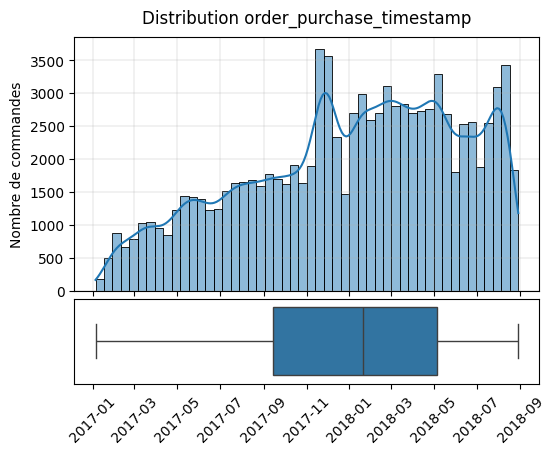

In [22]:
plot_distribution(df_data, 'order_purchase_timestamp', '', 'Nombre de commandes', x_tick_angle=45)

* La distribution ne présente plus d'outliers  
* Peu d'achats en début de période, ce qui suggère un début d'activité en janvier 2017

#### 2.3.3.2 Variable `total_price`

* Il s'agit d'une varibale calculée, qui totalise le montant dépensé par unité de produit (prix du produit + frais de livraison)

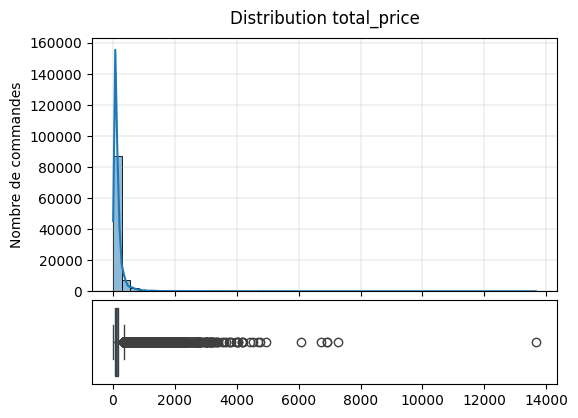

In [23]:
# Affichage de la distribution
plot_distribution(df_data, 'total_price', '', 'Nombre de commandes')

* La distribution est fortement asymétrique, avec une concentration de petits montants dépensés

#### 2.3.3.3 Variable `satisfaction`

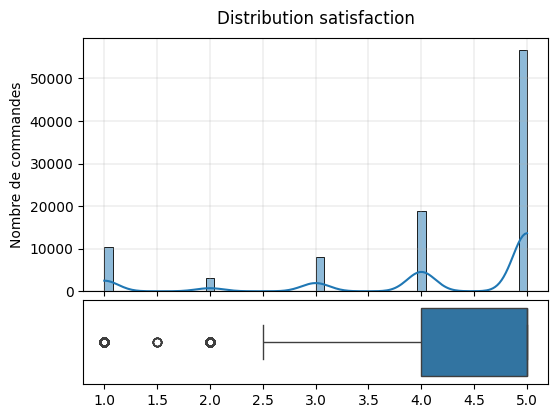

In [24]:
# Affichage de la distribution
plot_distribution(df_data, 'satisfaction', '', 'Nombre de commandes')

### 2.3.4 Sauvegarde du dataset

* Ce dataset constitue la base nécessaire pour le calcul des features RFM
* Il servira aussi de base pour la simulation du contrat de maintenance (Notebook 4)

In [25]:
# Sauvegarde pour simulation contrat de maintenance
df_data.to_csv('df_data.csv', index=False)

# 3 Création des features RFM

L'objectif est d'obtenir un dataset dont chaque ligne représente un client unique, avec les 3 features RFM :
* **Récence** : nombre de jours depuis la dernière commande  
* **Fréquence** : nombre de commandes passées
* **Montant** : total dépensé

Les algorithmes envisagés pour le clustering n'exigent pas que les distributions des features aient une forme particulière, mais les premiers tests ont montré des résultats décevant en cas de forte asymétrie.  
En revanche, ces mêmes algorithmes attendent des features mises à l'échelle :  
* **MinMaxScaler** normalise les données entre 0 et 1, sans changemet d'aspect de la distribution
* **StandardScaler** centre et réduit les données. La forme de la distribution est transformée, avec une moyenne à 0 et un écart-type à 1

D'autres transformations seront envisagées au cas par cas  

* Quelles que soient les transformations effectuées, lorsque les valeurs ne seront pas comprises entre 0 et 1 une mise à l'échelle via **MinMaxScaler** sera effectuée afin de s'assurer qu'une feature n'ait pas plus de poids que les autres dans le processus de segmentation.

## 3.1 Regroupements par client

* Rappel des variables disponibles

In [26]:
# Affichage des première lignes
display(df_data.head(3))

,customer_unique_id,customer_id,order_id,order_purchase_timestamp,total_price,satisfaction,year_month
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,146.87,4.0,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,29150127e6685892b6eab3eec79f59c7,2018-01-12,335.48,5.0,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19,157.73,5.0,2018-05


* Les champs `customer_id` et `order_id` font doublons entre eux, ils représentent chacun un numéro de commande différent, mais qui identifie la même commande
* Un regroupement par `customer_unique_id` permettra d'obtenir un ligne par client unique avec :
    * Le nombre de commandes qu'il a passé, en comptant le nombre de `customer_id` ou `order_id` correspondant  
    * La date de sa dernière commande, en prenant la plus récente `order_purchase_timestamp`  
    * Le montant total qu'il a dépensé, en additionant les `total_price` correspondants
    * Son score de satisfaction moyen, en faisant la moyenne des `satisfaction` correspondants

* Regroupements par client

In [27]:
# Regroupements
df_features = df_data.groupby('customer_unique_id').agg(
    nb_commandes = ('customer_id', 'count'),
    date_derniere_commande = ('order_purchase_timestamp', 'max'),
    montant_total = ('total_price', 'sum'),
    score_satisfaction = ('satisfaction', 'mean')
).reset_index()

In [28]:
# Affichage de quelques lignes
display(df_features)

,customer_unique_id,nb_commandes,date_derniere_commande,montant_total,score_satisfaction
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07,27.19,4.0
2,0000f46a3911fa3c0805444483337064,1,2017-03-10,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14,196.89,5.0
...,...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08,2067.42,5.0
94699,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10,84.58,4.0
94700,ffff371b4d645b6ecea244b27531430a,1,2017-02-07,112.46,5.0
94701,ffff5962728ec6157033ef9805bacc48,1,2018-05-02,133.69,5.0


In [29]:
# Informations sur les variables
display(get_dataframe_infos(df_features))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,customer_unique_id,object,94703,0,0,0.0 %
1,nb_commandes,int64,9,94694,0,0.0 %
2,date_derniere_commande,datetime64[ns],602,94101,0,0.0 %
3,montant_total,float64,31483,63220,0,0.0 %
4,score_satisfaction,float64,34,93990,679,0.72 %


* Ce regroupement a permis d'attribuer un score de satisfaction moyen à tous les clients qui ont répondu à au moins 1 enquête de satisfaction
* Avec seulement **0.72 %** des clients concernés, le remplacement des valeurs manquantes par le score de satisfaction médian ne dénaturera pas la pertinence de cette feature au niveau global

In [30]:
# Attribution du score de satisfaction médian aux clients n'ayant évalué aucune commande
df_features['score_satisfaction'] = df_features['score_satisfaction'].fillna(df_features['score_satisfaction'].median())

* Vérification

In [31]:
# Informations sur les variables
display(get_dataframe_infos(df_features))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,customer_unique_id,object,94703,0,0,0.0 %
1,nb_commandes,int64,9,94694,0,0.0 %
2,date_derniere_commande,datetime64[ns],602,94101,0,0.0 %
3,montant_total,float64,31483,63220,0,0.0 %
4,score_satisfaction,float64,34,94669,0,0.0 %


* Il n'y a plus de valeurs manquantes  
* Le fait qu'il n'y ait pas de doublons sur la variable `customer_unique_id` confirme que le dataset est rempli avec une ligne par client

## 3.2 Feature `Récence`

* **Récence** : nombre de jours écoulés depuis le dernier achat  

### 3.2.1 Calcul

In [32]:
# Dernier jour d'achat
last_order_date = df_features['date_derniere_commande'].max()

In [33]:
# Calcul de la feature 'Récence'
df_features['Récence'] = (last_order_date - df_features['date_derniere_commande']).dt.days

### 3.2.2 Distribution

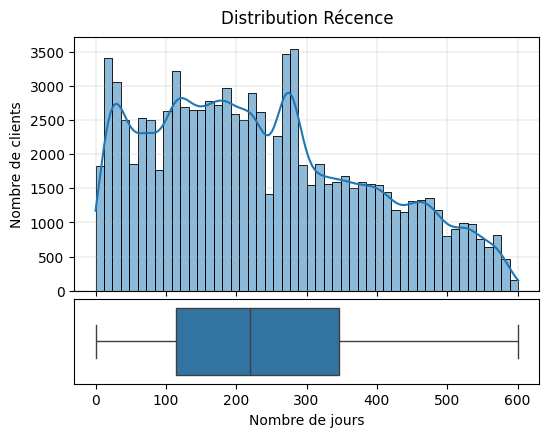

In [34]:
# Affichage de la distribution
plot_distribution(df_features, 'Récence', 'Nombre de jours', 'Nombre de clients')

### 3.2.3 Transformations

#### 3.2.3.1 StandardScaler

In [35]:
df_features['Récence_std'] = StandardScaler().fit_transform(df_features[['Récence']])

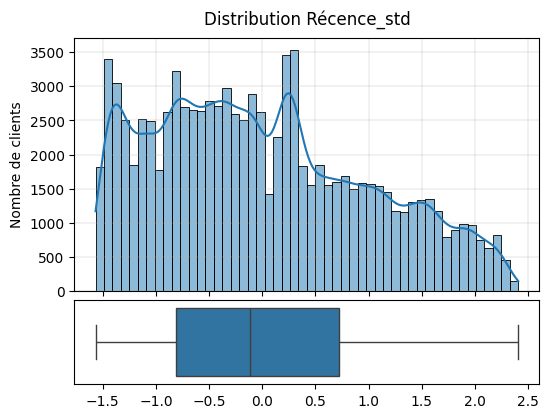

In [36]:
# Affichage de la distribution
plot_distribution(df_features, 'Récence_std', '', 'Nombre de clients')

* Version mise à l'échelle

In [37]:
df_features['Récence_std_minmax'] = MinMaxScaler().fit_transform(df_features[['Récence_std']])

#### 3.2.3.1 MinMaxScaler

In [38]:
df_features['Récence_minmax'] = MinMaxScaler().fit_transform(df_features[['Récence']])

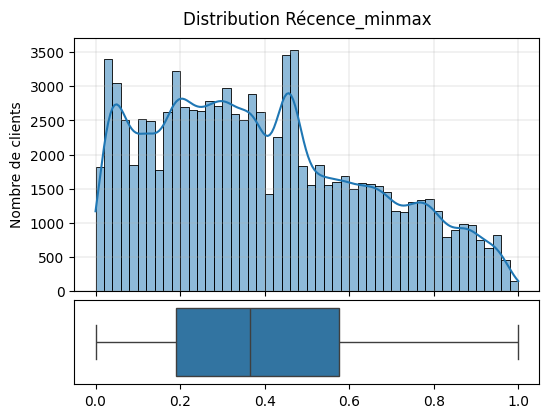

In [39]:
# Affichage de la distribution
plot_distribution(df_features, 'Récence_minmax', '', 'Nombre de clients')

## 3.3 Feature `Fréquence`

* **Fréquence** : nombre de commandes passées  

### 3.3.1 Calcul

* Ce calcul a déjà été réalisé lors du regroupement par client, dans la variable `nb_commandes`

### 3.3.2 Distribution

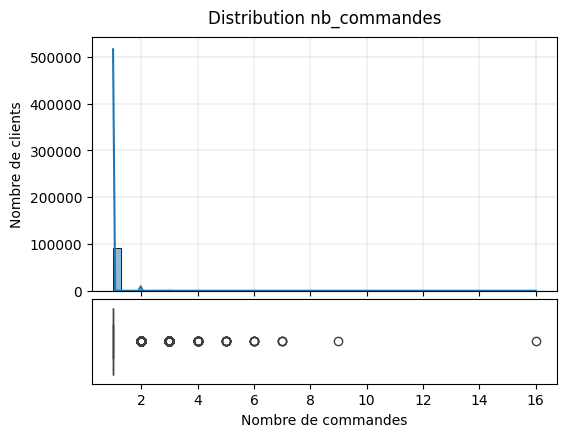

In [40]:
# Affichage de la distribution
plot_distribution(df_features, 'nb_commandes', 'Nombre de commandes', 'Nombre de clients')

* Cette distribution est fortement asymétrique, centrée autour de 1, avec beaucoup d'outliers  

In [41]:
# Répartition des clients par nombre de commandes
df_customers_by_number_of_orders = df_features['nb_commandes'].value_counts().to_frame().reset_index()
number_of_customers = df_features.shape[0]
df_customers_by_number_of_orders['%'] = round((df_customers_by_number_of_orders['count'] / number_of_customers) * 100, 2)
df_customers_by_number_of_orders.rename(columns={'count': 'Nbre de clients'}, inplace=True)
display(df_customers_by_number_of_orders)

,nb_commandes,Nbre de clients,%
0,1,91829,96.97
1,2,2639,2.79
2,3,187,0.20
3,4,29,0.03
4,5,9,0.01
5,6,5,0.01
6,7,3,0.00
7,9,1,0.00
8,16,1,0.00


* Presque **97 %** des clients n'ont passé qu'une seule commande
* Pour éviter des clusters avec de trop petits nombres de clients, la feature `Fréquence` peut être binarisée :
    * Les clients n'ayant passé qu'une seule commande se verront attribuer une `Fréquence` à **0**  
    * Les clients ayant commandé plusieurs fois, une `Fréquence` à **1**

In [42]:
# Binarisation de la feature `Fréquence`
mask = df_features['nb_commandes'] > 1
df_features['Fréquence'] = 0
df_features.loc[mask, 'Fréquence'] = 1

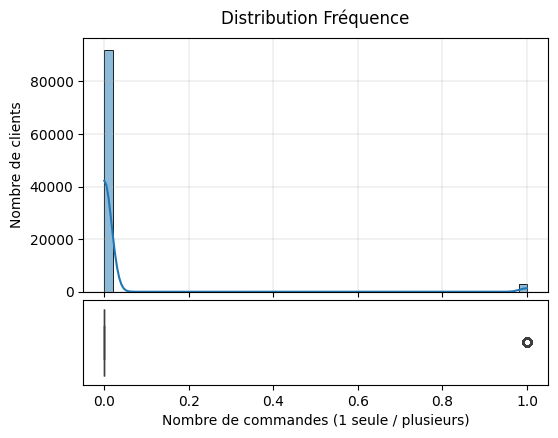

In [43]:
# Affichage de la distribution
plot_distribution(df_features, 'Fréquence', 'Nombre de commandes (1 seule / plusieurs)', 'Nombre de clients')

### 3.3.3 Transformations

* La binarisation de cette variable implique que sa distribution ne changera pas de forme, quelle que soit la transformation appliquée
* Les valeurs étant soit 0 soit 1, une mise à l'échelle via MinMaxScaler n'apporterait rien de plus

* Création d'une variable `Fréquence_minmax` par cohérence avec les autres

In [44]:
# Création feature `Fréquence_minmax` par recopie  
df_features['Fréquence_minmax'] = df_features['Fréquence']

## 3.4 Feature `Montant`

* **Montant** : montant total dépensé par un client

### 3.4.1 Calcul

* Feature déjà calculée lors du regroupement par client, dans la variable `montant_total`

In [45]:
# Changement de nom feature
df_features.rename(columns={'montant_total': 'Montant'}, inplace=True)

### 3.4.2 Distribution

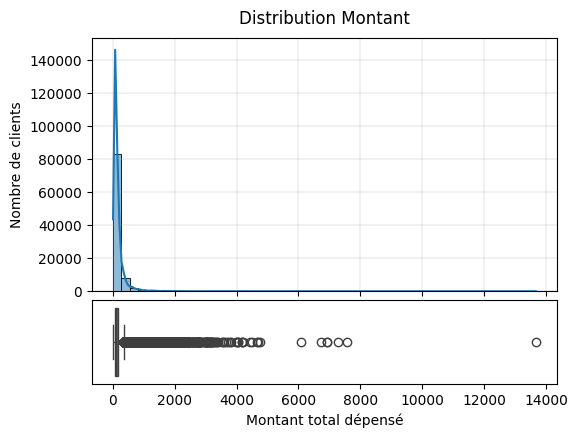

In [46]:
# Affichage de la distribution
plot_distribution(df_features, 'Montant', 'Montant total dépensé', 'Nombre de clients')

* La forte asymétrie qui existait avant le regroupement est encore plus présente
* Une solution pourrait être de considérer le panier moyen plutôt que le montant total, mais cela irait à l'encontre d'une analyse RFM

### 3.4.3 Transformations

#### 3.4.3.1 StandardScaler

In [47]:
df_features['Montant_std'] = StandardScaler().fit_transform(df_features[['Montant']])

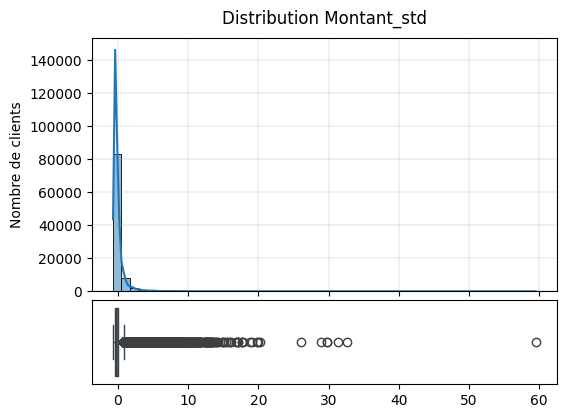

In [48]:
# Affichage de la distribution
plot_distribution(df_features, 'Montant_std', '', 'Nombre de clients')

* Version mise à l'échelle

In [49]:
df_features['Montant_std_minmax'] = MinMaxScaler().fit_transform(df_features[['Montant_std']])

#### 3.4.3.2 MinMaxScaler

In [50]:
df_features['Montant_minmax'] = MinMaxScaler().fit_transform(df_features[['Montant']])

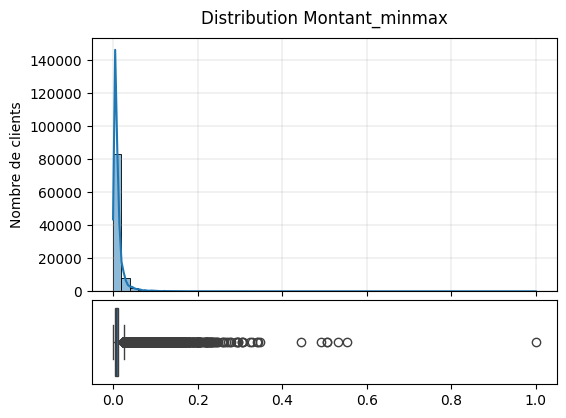

In [51]:
# Affichage de la distribution
plot_distribution(df_features, 'Montant_minmax', '', 'Nombre de clients')

#### 3.4.3.3 Log

In [52]:
df_features['Montant_log'] = np.log1p(df_features['Montant'])

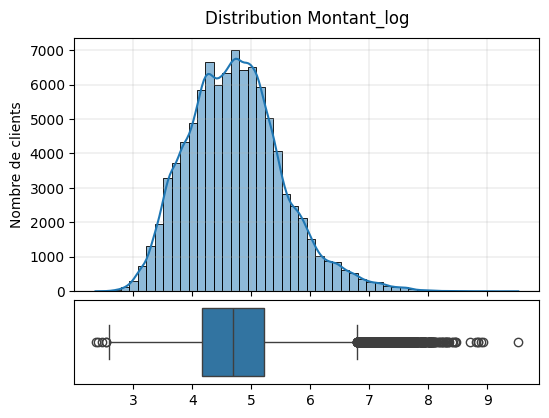

In [53]:
# Affichage de la distribution
plot_distribution(df_features, 'Montant_log', '', 'Nombre de clients')

* Version mise à l'échelle

In [54]:
df_features['Montant_log_minmax'] = MinMaxScaler().fit_transform(df_features[['Montant_log']])

#### 3.4.3.4 QuantileTransformer uniform

In [55]:
df_features['Montant_qtuni'] = QuantileTransformer(n_quantiles=500, output_distribution='uniform', random_state=0).fit_transform(df_features[['Montant']])

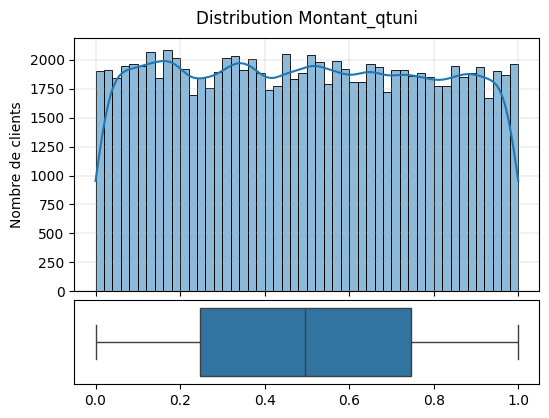

In [56]:
# Affichage de la distribution
plot_distribution(df_features, 'Montant_qtuni', '', 'Nombre de clients')

* Version mise à l'échelle

In [57]:
df_features['Montant_qtuni_minmax'] = MinMaxScaler().fit_transform(df_features[['Montant_qtuni']])

#### 3.4.3.5 QuantileTransformer normal

In [58]:
df_features['Montant_qtnorm'] = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=0).fit_transform(df_features[['Montant']])

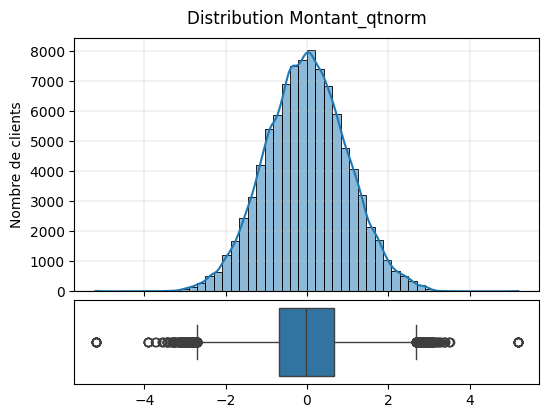

In [59]:
# Affichage de la distribution
plot_distribution(df_features, 'Montant_qtnorm', '', 'Nombre de clients')

* Version mise à l'échelle

In [60]:
df_features['Montant_qtnorm_minmax'] = MinMaxScaler().fit_transform(df_features[['Montant_qtnorm']])

#### 3.4.3.6 PowerTransformer Box-Cox

In [61]:
df_features['Montant_boxcox'] = PowerTransformer(method="box-cox").fit_transform(df_features[['Montant']])

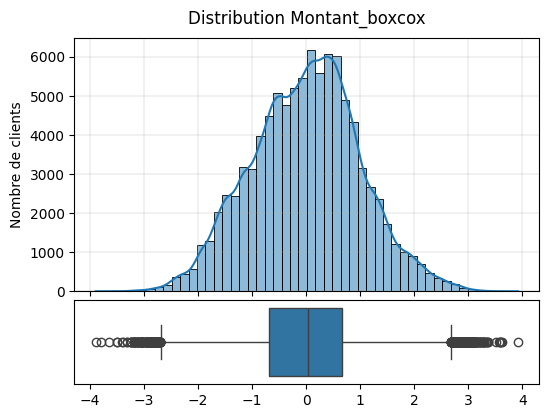

In [62]:
# Affichage de la distribution
plot_distribution(df_features, 'Montant_boxcox', '', 'Nombre de clients')

* Version mise à l'échelle

In [63]:
df_features['Montant_boxcox_minmax'] = MinMaxScaler().fit_transform(df_features[['Montant_boxcox']])

#### 3.4.3.7 Classement manuel

* Classements des montants en tranches facilement interprétables par l'équipe marketing

In [64]:
# Définition des bornes pour les intervalles de classement
bins = [0, 25, 50, 100, 150, 200, 250, 500, 1000, float('inf')]
labels = range(len(bins) - 1)

In [65]:
df_features['Montant_class'] = pd.cut(df_features['Montant'], bins=bins, labels=labels, right=False)

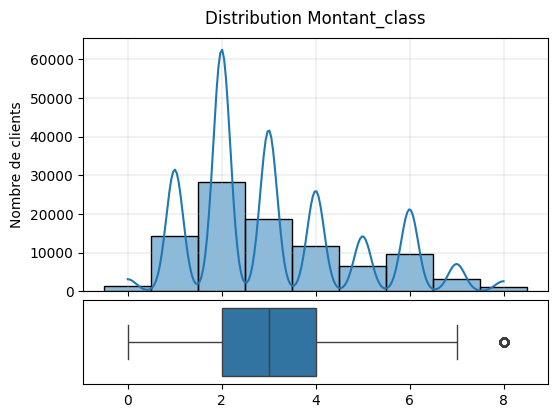

In [66]:
# Affichage de la distribution
plot_distribution(df_features, 'Montant_class', '', 'Nombre de clients')

* Version mise à l'échelle

In [67]:
df_features['Montant_class_minmax'] = MinMaxScaler().fit_transform(df_features[['Montant_class']])

## 4.3 Enregistrement du dataset

* Affichage du dataset `df_features`

In [68]:
# Affichage des premières et dernières lignes
display(df_features)

,customer_unique_id,nb_commandes,date_derniere_commande,Montant,score_satisfaction,Récence,Récence_std,Récence_std_minmax,Récence_minmax,Fréquence,...,Montant_log,Montant_log_minmax,Montant_qtuni,Montant_qtuni_minmax,Montant_qtnorm,Montant_qtnorm_minmax,Montant_boxcox,Montant_boxcox_minmax,Montant_class,Montant_class_minmax
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10,141.90,5.0,111,-0.833251,0.184692,0.184692,0,...,4.962145,0.363304,0.628237,0.628237,0.327188,0.531464,0.370629,0.545572,3,0.375
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07,27.19,4.0,114,-0.813411,0.189684,0.189684,0,...,3.338967,0.136688,0.021625,0.021625,-2.021285,0.305621,-1.964747,0.246742,1,0.125
2,0000f46a3911fa3c0805444483337064,1,2017-03-10,86.22,3.0,537,1.984066,0.893511,0.893511,0,...,4.468434,0.294376,0.386970,0.386970,-0.287226,0.472379,-0.253454,0.465715,2,0.250
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12,43.62,4.0,321,0.555567,0.534110,0.534110,0,...,3.798182,0.200801,0.120718,0.120718,-1.171404,0.387351,-1.215328,0.342636,1,0.125
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14,196.89,5.0,288,0.337324,0.479201,0.479201,0,...,5.287711,0.408757,0.775015,0.775015,0.755466,0.572650,0.747972,0.593856,4,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08,2067.42,5.0,447,1.388858,0.743760,0.743760,0,...,7.634540,0.736404,0.997999,0.997999,2.877937,0.776760,2.833938,0.860772,8,1.000
94699,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10,84.58,4.0,262,0.165375,0.435940,0.435940,0,...,4.449452,0.291726,0.377454,0.377454,-0.312176,0.469979,-0.278790,0.462473,2,0.250
94700,ffff371b4d645b6ecea244b27531430a,1,2017-02-07,112.46,5.0,568,2.189082,0.945092,0.945092,0,...,4.731450,0.331096,0.512692,0.512692,0.031819,0.503060,0.087169,0.509301,3,0.375
94701,ffff5962728ec6157033ef9805bacc48,1,2018-05-02,133.69,5.0,119,-0.780344,0.198003,0.198003,0,...,4.902976,0.355043,0.595808,0.595808,0.242511,0.523321,0.299239,0.536437,3,0.375


* Enregistrement

In [69]:
# Changement de nom 'customer_unique_id' -> 'Client'
df_features.rename(columns={'customer_unique_id': 'Client'}, inplace=True)

In [ ]:
# Enregistrement 'df_features.csv' dans le répertoire courant
df_features.to_csv('df_features.csv', index=False)